In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import qlib
import subprocess
import os
import vectorbt as vbt
import pandas_ta as ta

import warnings
warnings.filterwarnings("ignore")


qlib_root = r"E:\thunder download"
os.chdir(qlib_root)

In [11]:
qlib_root = r"E:\thunder download"
os.chdir(qlib_root)
etf_symbols = []
stock_symbols = []

with open("nasdaqtraded.txt", "r") as f:
    for line in f:
        if line.startswith("Nasdaq Traded") or not line.strip():
            continue

        parts = line.strip().split("|")
        if len(parts) < 7:
            continue

        traded_flag = parts[0]
        symbol = parts[1]
        is_etf = parts[5]

        if traded_flag != "Y":
            continue

        # 剔除非法符号和衍生后缀
        if any(substr in symbol for substr in ["$", "*", "=", "+", ".U", ".W", ".R", ".WS"]):
            continue

        if is_etf == "Y":
            etf_symbols.append(symbol)
        else:
            stock_symbols.append(symbol)

# 去重并排序
etf_symbols = sorted(set(etf_symbols))
stock_symbols = sorted(set(stock_symbols))

# 保存文件
with open("E:/data/qlib_data/test_us/us_etf_symbols.txt", "w") as f:
    for s in etf_symbols:
        f.write(s + "\n")

with open("E:/data/qlib_data/test_us/us_stock_symbols.txt", "w") as f:
    for s in stock_symbols:
        f.write(s + "\n")



In [ ]:
# Cell 1: 切到 qlib 根目录
import os
qlib_root = r"E:\thunder download\qlib"
os.chdir(qlib_root)

# Cell 2: 下载美股日线（测试2010版）
#!python scripts/get_data.py qlib_data --target_dir "E:/data/qlib_data/us_data" --region us --interval 1d
#这个能跑 原始下载from yahoo 完整版
#!python scripts/data_collector/yahoo/collector.py download_data --source_dir E:/data/qlib_data/test_us/source --region US --interval 1d --start 2000-01-01 --end 2025-07-21 --delay 0.4 
#标准化
#!python scripts/data_collector/yahoo/collector.py normalize_data --source_dir E:/data/qlib_data/us_data/source --normalize_dir E:/data/qlib_data/us_data/normalize --region US
#转储数据
#!python scripts/dump_bin.py dump_all --csv_path E:/data/qlib_data/us_data/normalize --qlib_dir E:/data/qlib_data/us_data/US_data
#输出spy列表
#!python collector.py --index_name SP500 --qlib_dir ~/.qlib/qlib_data/us_data --method parse_instruments
#更新数据
#!python scripts/data_collector/yahoo/collector.py update_data_to_bin --qlib_data_1d_dir E:/data/qlib_data/us_data/US_data --end_date 2025-07-18 --region US --delay 0.4

In [ ]:
qlib.init(provider_uri="E:/data/qlib_data/us_data/US_data", region="us")
df = D.features(D.instruments("all"), ["$close"], freq="day")

## https://qlib.readthedocs.io/en/latest/start/getdata.html

## 新框架测试
# covered call 优化版信号识别模型

In [6]:
# Cell 4: 初始化 Qlib 验证
import qlib
from qlib.config import REG_US
from qlib.data import D
qlib.init(provider_uri="E:/data/qlib_data/us_data/US_data", region=REG_US)
instruments = ['NK225MINI']

[23640:MainThread](2025-08-05 21:07:36,031) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[23640:MainThread](2025-08-05 21:07:38,121) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[23640:MainThread](2025-08-05 21:07:38,122) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('E:/data/qlib_data/us_data/US_data')}


In [ ]:
df = D.features(
    instruments=instruments,
    fields=["$open", "$high", "$low", "$close", "$volume"],
    start_time="2007-01-01",
    end_time="2025-7-28",
    freq="day"
)

In [2]:
import pandas as pd

# 1. 读取Excel文件中的「終日日足」Sheet
file_path = "N225minif_2025.xlsx"   # ← 你的实际文件名
sheet_name = "終日日足"

# 2. 读取数据
df = pd.read_excel(file_path, sheet_name=sheet_name)

# 3. 字段名规范化（假设原始字段名为：日付、始値、高値、安値、終値、出来高）
df = df.rename(columns={
    "日付": "datetime",      # 日期
    "始値": "$open",         # 开盘价
    "高値": "$high",         # 最高价
    "安値": "$low",          # 最低价
    "終値": "$close",        # 收盘价
    "出来高": "$volume"      # 成交量
})

# 4. 转换日期格式，并按时间排序
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").set_index("datetime")

# 5. 保留标准Qlib格式的五列
qlib_df = df[["$open", "$high", "$low", "$close", "$volume"]].copy()

print(qlib_df.head())


            $open  $high   $low  $close  $volume
datetime                                        
2006-07-18  14680  14715  14400   14400    22345
2006-07-19  14500  14650  14465   14560    20646
2006-07-20  14860  14975  14780   14975    17398
2006-07-21  14840  14875  14790   14820    14689
2006-07-24  14685  14870  14560   14775    22641


In [ ]:
df = qlib_df
# Step 3: Generate simple technical indicators using pandas_ta
df["SMA_5"] = ta.sma(df["$close"], length=5)
df["SMA_20"] = ta.sma(df["$close"], length=20)
df["ROC_5"] = ta.roc(df["$close"], length=5)

# Step 4: Define signal: SMA_5 > SMA_20 and ROC_5 > 0
signal = (df["SMA_5"] > df["SMA_20"]) & (df["ROC_5"] > 0)

# Step 5: Set entry and exit
entries = signal
exits = signal.shift(7).fillna(False)  # Exit after 7 days

# Step 6: Run portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df["$close"],
    entries=entries,
    exits=exits,
    size=1.0,
    direction="longonly",
    fees=0.0,
    slippage=0.0
)

# Step 7: Collect stats
stats = portfolio.stats()

C:\Users\602599140\AppData\Local\Temp\ipykernel_23640\803312496.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exits = signal.shift(7).fillna(False)  # Exit after 7 days
C:\Users\602599140\AppData\Roaming\Python\Python312\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\602599140\AppData\Roaming\Python\Python312\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\602599140\AppData\Roaming\Python\Python312\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)

🔍 行为分析统计结果：
总信号触发次数：231
未来7日平均收益：0.37%
下跌概率（第7日收盘低于入场价）：45.9%
触发止损概率（回撤超过 -2.5%）：41.1%
平均最大回撤：-2.62%


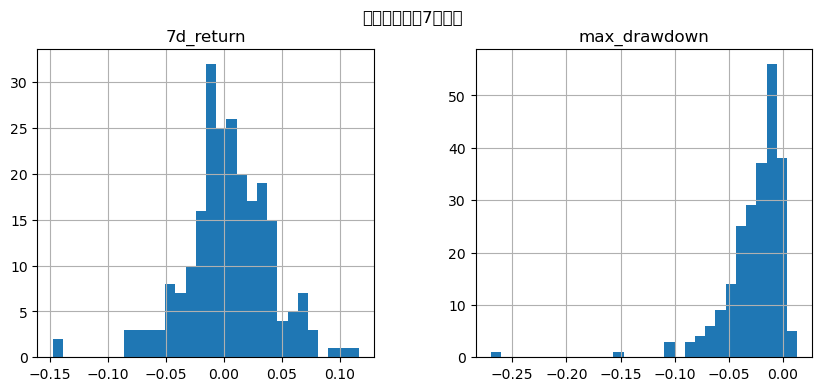

In [10]:
df = qlib_df
# 假设 df 中包含 $close, $volume 等
df["ROC_8"] = ta.roc(df["$close"], length=8)
df["ROC_1"] = ta.roc(df["$close"], length=1)
df["ATR_14"] = ta.atr(df["$high"], df["$low"], df["$close"], length=14)
df["RSI_14"] = ta.rsi(df["$close"], length=14)
df["MA50"] = ta.sma(df["$close"], length=50)
df["MA20"] = ta.sma(df["$close"], length=20)

# -----------信号逻辑：未来更可能“横盘或缓涨”-----------
signal = (
    (df["ROC_8"] > 0) &              # 中期动量偏强
    (df["ROC_1"] >= -0.005) &             # 短期没下跌
    (abs(df["RSI_14"] - 50) < 20) &    # RSI靠近中性，表明盘整可能
    (df["$close"] > df["MA50"]) & # 长期趋势
    (df["MA20"].diff() > 0)
)

# 3. 确定每次信号触发的日期和入场价格
entry_dates = df.index[signal]
entry_prices = df["$close"].loc[entry_dates]

# 4. 设置分析参数
horizon = 10  # 回测窗口
stop_loss_ratio = -0.025  # 止损阈值（如 -0.03 表示 -3%）

# 5. 回测逻辑
results = []
next_entry_idx = 0  # 初始化允许开仓的最早索引位置

for dt in entry_dates:
    if dt not in df.index:
        continue

    entry_idx = df.index.get_loc(dt)

    # ⛔ 如果当前信号日期小于下一次允许开仓的索引，则跳过（冷却期内）
    if entry_idx < next_entry_idx:
        continue

    try:
        future_data = df.iloc[entry_idx + 1 : entry_idx + 1 + horizon]
        if len(future_data) < horizon:
            continue

        entry_price = df.loc[dt, "$close"]
        end_price = future_data.iloc[-1]["$close"]
        min_price = future_data["$low"].min()

        # 触发止损日期
        stop_loss_hit = False
        stop_loss_date = None
        for i, row in future_data.iterrows():
            if (row["$low"] - entry_price) / entry_price < stop_loss_ratio:
                stop_loss_hit = True
                stop_loss_date = row.name  # 注意：index 是 datetime
                break

        ret_7d = (end_price - entry_price) / entry_price
        drawdown = (min_price - entry_price) / entry_price
        ended_down = ret_7d < 0
        is_success = (not stop_loss_hit)  # 如果你想定义成功为“未触发止损”，就这样
        # 或者更严格一些：
        # is_success = (not stop_loss_hit) and (not ended_down)
        exit_date = stop_loss_date if stop_loss_hit else future_data.index[-1]

        results.append({
            "entry_date": dt,
            "7d_return": ret_7d,
            "exit_date": exit_date,
            "max_drawdown": drawdown,
            "stop_loss_hit": stop_loss_hit,
            "stop_loss_date": stop_loss_date,
            "ended_down": ended_down,
            "success": is_success  # ✅ 添加成功标志
        
        })

        # ✅ 更新下一次允许开仓的索引
        next_entry_idx = entry_idx + horizon

    except:
        continue

# 6. 输出统计
res_df = pd.DataFrame(results)
print("🔍 行为分析统计结果：")
print(f"总信号触发次数：{len(res_df)}")
print(f"未来7日平均收益：{res_df['7d_return'].mean():.2%}")
print(f"下跌概率（第7日收盘低于入场价）：{res_df['ended_down'].mean():.1%}")
print(f"触发止损概率（回撤超过 {stop_loss_ratio:.1%}）：{res_df['stop_loss_hit'].mean():.1%}")
print(f"平均最大回撤：{res_df['max_drawdown'].mean():.2%}")

# 7. 可视化
import matplotlib.pyplot as plt

res_df[["7d_return", "max_drawdown"]].hist(bins=30, figsize=(10, 4))
plt.suptitle("行为信号未来7日表现")
plt.show()

In [11]:
import plotly.graph_objects as go

# ✅ 复制 df 以防污染
df_plot = df.copy()

# 提取各类日期
entry_dates = res_df["entry_date"]
stop_loss_dates = res_df.loc[res_df["stop_loss_hit"], "stop_loss_date"].dropna()
success_dates = res_df.loc[~res_df["stop_loss_hit"], "exit_date"].dropna()

# 主图：收盘价曲线
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot["$close"],
    mode='lines',
    name='Close Price',
    line=dict(color='lightgray')
))

# ✅ 开仓点：绿色圆圈
fig.add_trace(go.Scatter(
    x=entry_dates,
    y=df_plot.loc[entry_dates, "$close"],
    mode='markers',
    name='Entry Signal',
    marker=dict(color='green', size=13, symbol='circle')
))

# ❌ 止损点：红色叉
fig.add_trace(go.Scatter(
    x=stop_loss_dates,
    y=df_plot.loc[stop_loss_dates, "$close"],
    mode='markers',
    name='Stop-Loss',
    marker=dict(color='red', size=10, symbol='x')
))

# ✅ 成功出场点：蓝色菱形
fig.add_trace(go.Scatter(
    x=success_dates,
    y=df_plot.loc[success_dates, "$close"],
    mode='markers',
    name='Exit (Success)',
    marker=dict(color='blue', size=8, symbol='diamond')
))

# 美化图表
fig.update_layout(
    title="📊 NK225MINI 信号行为分析图（Covered Call 策略）",
    xaxis_title="Date",
    yaxis_title="Close Price",
    height=600,
    legend=dict(x=0.01, y=0.99),
)

fig.show()


In [11]:
stats

Start                         (NK225MINI, 2009-05-01 00:00:00)
End                           (NK225MINI, 2025-07-28 00:00:00)
Period                                                    4006
Start Value                                              100.0
End Value                                           146.123562
Total Return [%]                                     46.123562
Benchmark Return [%]                                352.794695
Max Gross Exposure [%]                                   100.0
Total Fees Paid                                            0.0
Max Drawdown [%]                                     30.040831
Max Drawdown Duration                                   1949.0
Total Trades                                               187
Total Closed Trades                                        186
Total Open Trades                                            1
Open Trade PnL                                        3.482534
Win Rate [%]                                         44

In [ ]:
#alpha 适用于ml的输入特征无法相互比较
df = Alpha158(
    instruments=["NK225MINI"],
    start_time="2010-01-01",
    end_time="2025-07-18",
    fit_start_time="2010-01-01",
    fit_end_time="2025-07-18",
    infer_processors=[]
).fetch()

[3076:MainThread](2025-08-04 22:01:12,912) INFO - qlib.timer - [log.py:127] - Time cost: 0.052s | Loading data Done
[3076:MainThread](2025-08-04 22:01:12,919) INFO - qlib.timer - [log.py:127] - Time cost: 0.002s | DropnaLabel Done
[3076:MainThread](2025-08-04 22:01:16,884) INFO - qlib.timer - [log.py:127] - Time cost: 3.965s | CSZScoreNorm Done
[3076:MainThread](2025-08-04 22:01:16,884) INFO - qlib.timer - [log.py:127] - Time cost: 3.972s | fit & process data Done
[3076:MainThread](2025-08-04 22:01:16,884) INFO - qlib.timer - [log.py:127] - Time cost: 4.025s | Init data Done


In [ ]:
df

,,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,...,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60,LABEL0
datetime,instrument,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NK225MINI,0.004247,0.010382,0.409091,0.005663,0.545455,0.000472,0.045455,-0.000944,-0.090909,0.995771,...,0.576720,0.565180,0.521629,0.503010,-0.089757,-0.153440,-0.130360,-0.043258,-0.006020,0.002338
2010-01-05,NK225MINI,-0.007885,0.012987,-0.607143,0.001855,0.142857,0.003247,0.250000,-0.006494,-0.500000,1.007948,...,0.414241,0.532436,0.484342,0.472519,0.760401,0.171519,-0.064873,0.031316,0.054962,-0.002332
2010-01-06,NK225MINI,0.000000,0.010728,0.000000,0.005131,0.478261,0.005597,0.521739,0.000466,0.043478,1.000000,...,0.481314,0.514820,0.513796,0.486732,0.393264,0.037372,-0.029640,-0.027592,0.026537,0.011220
2010-01-07,NK225MINI,-0.004190,0.013035,-0.321429,0.003259,0.250000,0.005587,0.428571,-0.001862,-0.142857,1.004208,...,0.358198,0.510624,0.499639,0.490667,0.216969,0.283604,-0.021247,0.000723,0.018665,0.008322
2010-01-08,NK225MINI,0.004178,0.014856,0.281250,0.001393,0.093750,0.009285,0.625000,0.012071,0.812500,0.995839,...,0.375573,0.453122,0.473132,0.482583,0.333625,0.248854,0.093757,0.053737,0.034833,-0.016506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-14,NK225MINI,0.001270,0.008130,0.156250,0.004954,0.609375,0.001905,0.234375,-0.001778,-0.218750,0.998731,...,0.645186,0.515638,0.500549,0.500889,0.066005,-0.290371,-0.031276,-0.001098,-0.001777,-0.001639
2025-07-15,NK225MINI,0.002528,0.007711,0.327869,0.000506,0.065574,0.004677,0.606557,0.006700,0.868852,0.997478,...,0.571477,0.477507,0.486521,0.496068,-0.011319,-0.142955,0.044987,0.026959,0.007863,0.008714
2025-07-16,NK225MINI,-0.000253,0.010227,-0.024691,0.007955,0.777778,0.002020,0.197531,-0.006187,-0.604938,1.000253,...,0.539630,0.474713,0.477277,0.499745,0.394400,-0.079259,0.050575,0.045446,0.000509,-0.002504


In [34]:
df.to_csv("nk225mini_alpha159.csv")

In [45]:
import qlib
from qlib.data import D
from qlib.config import REG_US
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qlib.contrib.data.handler import Alpha158

# 初始化 Qlib
#qlib.init(provider_uri="E:/data/qlib_data/us_data/US_data", region=REG_US)

# ---------------------
# 参数设置
instruments = ['NK225MINI']
start_time = "2007-01-01"
end_time = "2025-07-18"
forecast_horizon = 5  # 未来几天
threshold_return = -0.01  # 定义"下跌"的阈值（如回撤超过1%）

# ---------------------
# 使用 Alpha158 生成因子数据
df = Alpha158(
    instruments=["NK225MINI"],
    start_time="2010-01-01",
    end_time="2025-07-18",
    #fit_start_time="2010-01-01",
    #fit_end_time="2025-07-18",
    infer_processors=[],#标准化for ml\
    learn_processors=[],
).fetch()
#df = df.dropna()

# 因子命名需精确匹配 Alpha158 输出，如 "MA5", "MA20", "ROC5", "STD20"
#factor_cols = ["MA5", "MA20", "ROC5", "STD20", "LABEL0"]
#df = df.dropna(subset=factor_cols)  # 避免因子 NaN 导致丢行



[3076:MainThread](2025-08-04 23:10:27,368) INFO - qlib.timer - [log.py:127] - Time cost: 0.060s | Loading data Done
[3076:MainThread](2025-08-04 23:10:27,368) INFO - qlib.timer - [log.py:127] - Time cost: 0.000s | fit & process data Done
[3076:MainThread](2025-08-04 23:10:27,370) INFO - qlib.timer - [log.py:127] - Time cost: 0.062s | Init data Done


In [46]:
df

,,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,...,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60,LABEL0
datetime,instrument,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NK225MINI,0.004247,0.010382,0.409091,0.005663,0.545455,0.000472,0.045455,-0.000944,-0.090909,0.995771,...,0.576720,0.565180,0.521629,0.503010,-0.089757,-0.153440,-0.130360,-0.043258,-0.006020,0.002338
2010-01-05,NK225MINI,-0.007885,0.012987,-0.607143,0.001855,0.142857,0.003247,0.250000,-0.006494,-0.500000,1.007948,...,0.414241,0.532436,0.484342,0.472519,0.760401,0.171519,-0.064873,0.031316,0.054962,-0.002332
2010-01-06,NK225MINI,0.000000,0.010728,0.000000,0.005131,0.478261,0.005597,0.521739,0.000466,0.043478,1.000000,...,0.481314,0.514820,0.513796,0.486732,0.393264,0.037372,-0.029640,-0.027592,0.026537,0.011220
2010-01-07,NK225MINI,-0.004190,0.013035,-0.321429,0.003259,0.250000,0.005587,0.428571,-0.001862,-0.142857,1.004208,...,0.358198,0.510624,0.499639,0.490667,0.216969,0.283604,-0.021247,0.000723,0.018665,0.008322
2010-01-08,NK225MINI,0.004178,0.014856,0.281250,0.001393,0.093750,0.009285,0.625000,0.012071,0.812500,0.995839,...,0.375573,0.453122,0.473132,0.482583,0.333625,0.248854,0.093757,0.053737,0.034833,-0.016506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-14,NK225MINI,0.001270,0.008130,0.156250,0.004954,0.609375,0.001905,0.234375,-0.001778,-0.218750,0.998731,...,0.645186,0.515638,0.500549,0.500889,0.066005,-0.290371,-0.031276,-0.001098,-0.001777,-0.001639
2025-07-15,NK225MINI,0.002528,0.007711,0.327869,0.000506,0.065574,0.004677,0.606557,0.006700,0.868852,0.997478,...,0.571477,0.477507,0.486521,0.496068,-0.011319,-0.142955,0.044987,0.026959,0.007863,0.008714
2025-07-16,NK225MINI,-0.000253,0.010227,-0.024691,0.007955,0.777778,0.002020,0.197531,-0.006187,-0.604938,1.000253,...,0.539630,0.474713,0.477277,0.499745,0.394400,-0.079259,0.050575,0.045446,0.000509,-0.002504


In [38]:
# 参数设置
forecast_horizon = 7
stop_loss_ratio = -0.03  # 例如 -3%
threshold_dd = stop_loss_ratio

# 策略信号（示例：均线+动量）
signal = (df["MA5"] > df["MA20"]) & (df["ROC5"] > 0)
signal_df = df[signal].copy()

# 收益与最大回撤（未来 horizon 日）
future_returns = []
hit_stop_loss = []
max_drawdowns = []

close_series = df["CLOSE0"]
low_series = df["LOW0"] if "LOW0" in df.columns else None

for dt in signal_df.index:
    try:
        cur_price = close_series.loc[dt]
        future_prices = close_series.loc[dt:].iloc[1:forecast_horizon + 1]
        future_lows = low_series.loc[dt:].iloc[1:forecast_horizon + 1] if low_series is not None else None

        # 收益：末日价格 - 入场价
        ret = (future_prices[-1] - cur_price) / cur_price
        future_returns.append(ret)

        # 最大回撤 = 最低价 - 入场价
        if future_lows is not None:
            dd = (future_lows.min() - cur_price) / cur_price
            max_drawdowns.append(dd)
            hit_stop_loss.append(dd < stop_loss_ratio)  # 是否触发止损
        else:
            max_drawdowns.append(None)
            hit_stop_loss.append(None)
    except:
        continue

# -------------------
# 汇总结果
res_df = pd.DataFrame({
    "future_return": future_returns,
    "max_drawdown": max_drawdowns,
    "hit_stop": hit_stop_loss
}).dropna()

print("📊 策略统计结果：")
print(f"✅ 信号总触发次数：{len(res_df)}")
print(f"📈 平均未来{forecast_horizon}日收益：{res_df['future_return'].mean():.3%}")
print(f"✔️ 胜率（收益 > 0）：{(res_df['future_return'] > 0).mean():.1%}")
print(f"⛔ 触发止损（跌破 {stop_loss_ratio:.1%}）的概率：{res_df['hit_stop'].mean():.1%}")
print(f"📉 平均最大回撤：{res_df['max_drawdown'].mean():.2%}")

# 可视化（收益分布）
res_df["future_return"].hist(bins=30)
plt.title(f"未来{forecast_horizon}日收益分布")
plt.xlabel("Return")
plt.grid()
plt.show()

KeyError: 'CLOSE0'

,,$close,$MA_20,$MA_60,$RETURN_5
instrument,datetime,,,,
